In [1]:
!pip install -r requirements.txt --quiet




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
import networkx as nx
import causalgraphicalmodels
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

plt.style.use(['seaborn-v0_8-darkgrid','seaborn-v0_8-colorblind'])

#### Code 5.1

In [3]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')

d['A'] = scale.fit_transform(d[['MedianAgeMarriage']]).squeeze()
d['D'] = scale.fit_transform(d[['Divorce']]).squeeze()

#### Code 5.2

In [4]:
d.MedianAgeMarriage.std()

1.2436303013880823

#### Code 5.3

In [6]:
with pm.Model() as m5_1: 
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', 0, .5)
    a = pm.Normal('a', 0, .2)
    mu = pm.Deterministic('mu', a + bA * d.A)
    D = pm.Normal('D', mu = mu, sigma = sigma, observed=d.D)
    trace_m5_1 = pm.sample(1000, tune = 100, cores = 1)



Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bA, a]


Output()

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Code 5.4

_In chapter 4 we broke down how to generate your own sampling for prior predictors. Going forward there's a much easier way using PYMC's pm.sample_prior_predictive() so we'll be using that going forward though it roughly does the same thing as we did before._

Sampling: [D, a, bA, sigma]


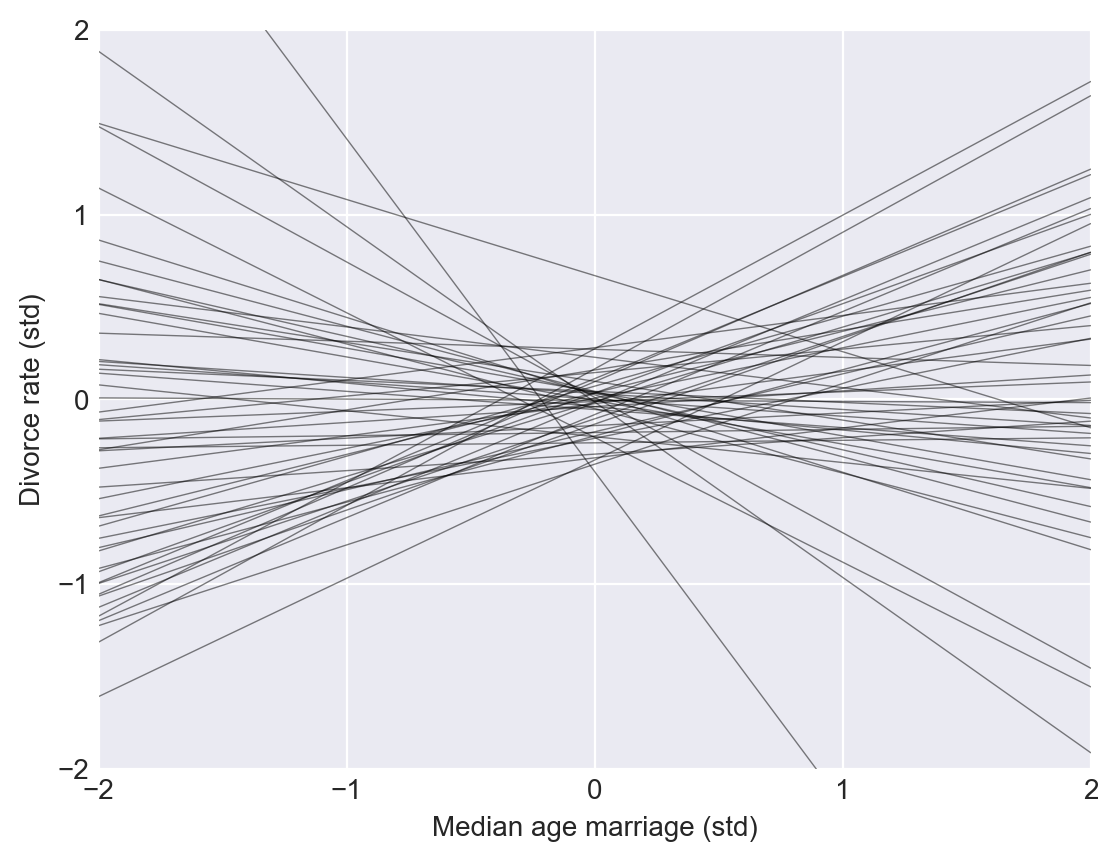

In [7]:
N = 1000
with m5_1:
    prior = pm.sample_prior_predictive(N)
post = prior.prior[['a','bA','sigma']].to_dataframe().reset_index()
data = np.linspace(-2,2,N)


for i in range(50):
    mu = post.a[i] + (post.bA[i] * data)
    plt.plot(data, mu, color = 'black', lw = .5, alpha = .5)
plt.xlabel('Median age marriage (std)')
plt.ylabel('Divorce rate (std)')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2]);

#### Code 5.5

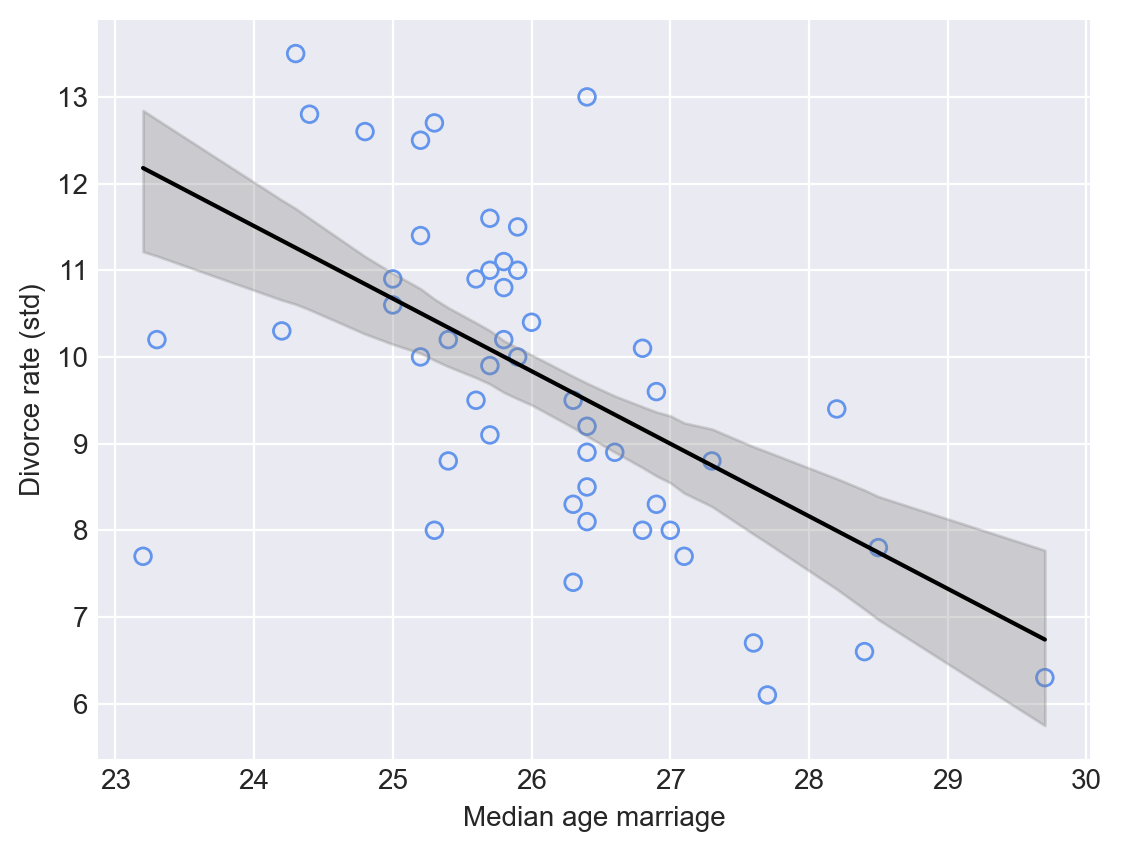

In [8]:
age_idx = np.argsort(d.MedianAgeMarriage)
age_sort = np.sort(d.MedianAgeMarriage)

mu_all = trace_m5_1.posterior.mu.values  

m5_1_mu_means = mu_all.mean(axis=(0, 1)) 

mu_flat = mu_all.reshape(-1, mu_all.shape[-1]) 

m5_1_mu_hdi = az.hdi(mu_flat, hdi_prob=0.89)

m5_1_mu_means_sorted = m5_1_mu_means[age_idx] * d.Divorce.std() + d.Divorce.mean()
m5_1_mu_hdi_sorted = m5_1_mu_hdi[age_idx]* d.Divorce.std() + d.Divorce.mean()

plt.scatter(d.MedianAgeMarriage, d.Divorce, edgecolors='cornflowerblue', facecolors='none')
plt.plot(age_sort, m5_1_mu_means_sorted * d.D.std() + d.D.mean(), color='black')
plt.fill_between(age_sort, m5_1_mu_hdi_sorted[:,0], m5_1_mu_hdi_sorted[:,1], color='grey', alpha=0.3)
plt.xlabel('Median age marriage')
plt.ylabel('Divorce rate (std)');


#### Code 5.6

In [9]:
d['M'] = scale.fit_transform(d[['Marriage']]).squeeze()
with pm.Model() as m5_2:
    sigma = pm.Exponential('s', 1)
    bM = pm.Normal('bM', mu = 0, sigma = .5)
    a = pm.Normal('a', mu = 0, sigma = .2)
    mu = pm.Deterministic('mu', a + bM * d.M)

    D = pm.Normal('D_i', mu = mu, sigma = sigma, observed = d.D)
    trace_m5_2 = pm.sample(1000, tune = 100, cores = 1)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [s, bM, a]


Output()

Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


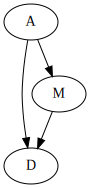

[]

In [ ]:
model = CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[("A", "M"), ("A", "D"), ("M","D")],
)


# List conditional independencies implied by the DAG
display(model.draw())
model.get_all_independence_relationships()

#### Code 5.8

[('D', 'M', {'A'})]


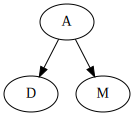

In [11]:
model = CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[("A", "M"), ("A", "D")],

)

print(model.get_all_independence_relationships())
model.draw()

#### Code 5.9

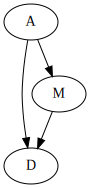

[]

In [12]:
model = CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[("A", "M"), ("A", "D"), ("M","D")],
)

display(model.draw())
model.get_all_independence_relationships()

#### Code 5.10

In [13]:
with pm.Model() as m5_3: 
    sigma = pm.Exponential('sigma', 1)
    bA = pm.Normal('bA', 0, .5)
    bm = pm.Normal('bM',0, .5)
    a = pm.Normal('a',0, .2)
    mu = pm.Deterministic('mu', a + bm * d.M + bA * d.A)
    D = pm.Normal('D', mu = mu, sigma = sigma, observed = d.D)
    trace_m5_3 = pm.sample(1000, tune = 100, cores = 1, chains = 4)
    post_m5_3 = pm.sample_posterior_predictive(trace_m5_3)
pm.summary(trace_m5_3.posterior[['a', 'bA', 'bM', 'sigma']])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bA, bM, a]


Output()

Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 2 seconds.
Sampling: [D]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.101,-0.185,0.189,0.002,0.002,4498.0,3089.0,1.0
bA,-0.607,0.161,-0.907,-0.311,0.004,0.003,1835.0,1934.0,1.0
bM,-0.061,0.158,-0.372,0.221,0.004,0.003,1732.0,2254.0,1.0
sigma,0.838,0.087,0.672,0.997,0.001,0.001,3975.0,2971.0,1.0


#### Code 5.11

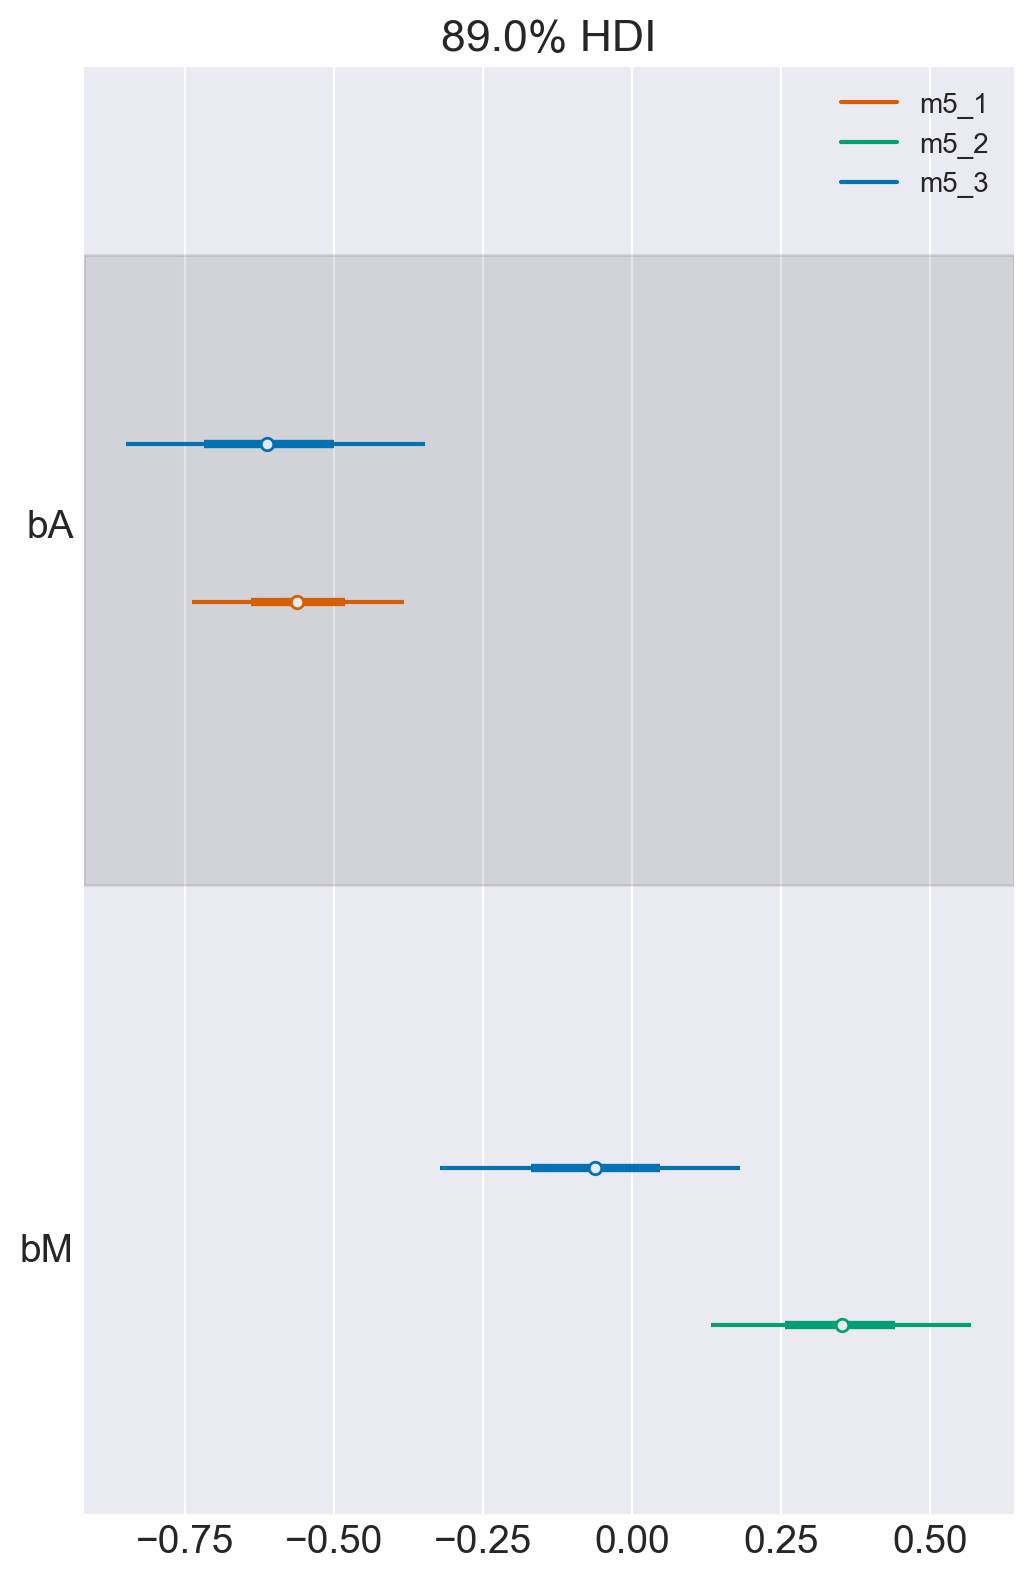

In [14]:
az.plot_forest(
    [trace_m5_3, trace_m5_2, trace_m5_1],
    var_names=['bA', 'bM'],
    combined=True,
    model_names=["m5_3", "m5_2", "m5_1"],
    hdi_prob=0.89,
    
);

#### Code 5.12

In [15]:
N = 50 
age = np.random.normal(0,1,N) 
mar = np.random.normal(-age, 1,N) 
div = np.random.normal(age, 1, N) ;



#### Code 5.13

In [16]:
with pm.Model() as m5_4:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu = 0, sigma = .2)
    bAM = pm.Normal('bAM', mu = 0, sigma = .5)
    mu = pm.Deterministic('mu', a + bAM * d.A)

    M = pm.Normal('M', mu = mu, sigma = sigma, observed = d.M)
    m5_4_trace = pm.sample(1000, tune = 1000, cores = 1, chains = 4, progressbar = False)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bAM]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### Code 5.14

In [17]:
m5_4_mu_means = m5_4_trace.posterior.mu.sel(chain = 1).values.mean(0)

m5_4_mu_resid = d.M - m5_4_mu_means

#### Code 5.15

In [18]:

mu = trace_m5_3.posterior.mu.sel(chain =1).values

#summarize samples across cases
mu_means = mu.mean(0)
mu_PI = az.hdi(mu, hdi_prob = .89)

with m5_3:
    post = pm.sample_posterior_predictive(trace_m5_3) 

# simulate observations 
# again no new data, so uses original data    
D_sim = post.posterior_predictive.D.sel(chain =1).values.mean(0)
D_pi = az.hdi(D_sim, hdi_prob = .89)


Sampling: [D]


Output()

#### Code 5.16

Text(0, 0.5, 'Predicted divorce')

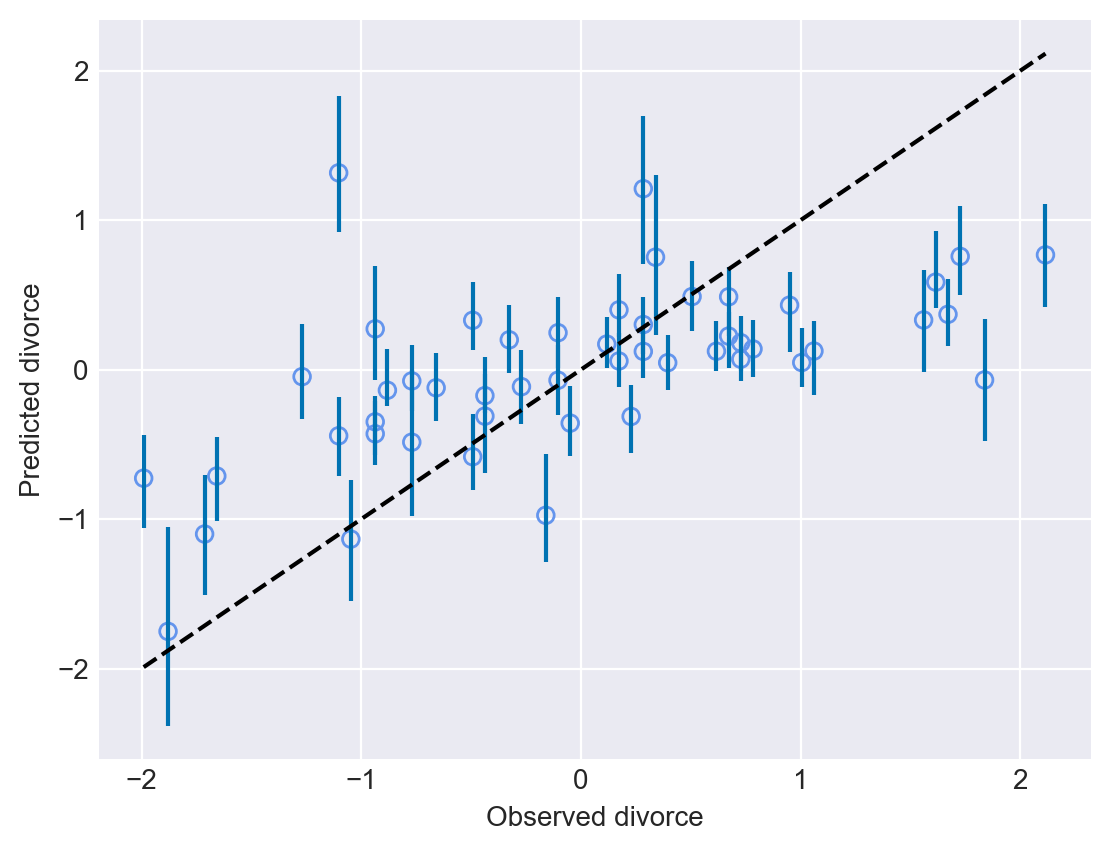

In [19]:
plt.scatter(d.D, mu_means, edgecolors = 'cornflowerblue', facecolors = 'none');
plt.errorbar(d.D, D_sim, yerr=np.abs(mu_means - mu_PI.T), fmt = 'none')
plt.plot([d.D.min(), d.D.max()], [d.D.min(), d.D.max()], linestyle='dashed', color='black')
plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

#### Code 5.17

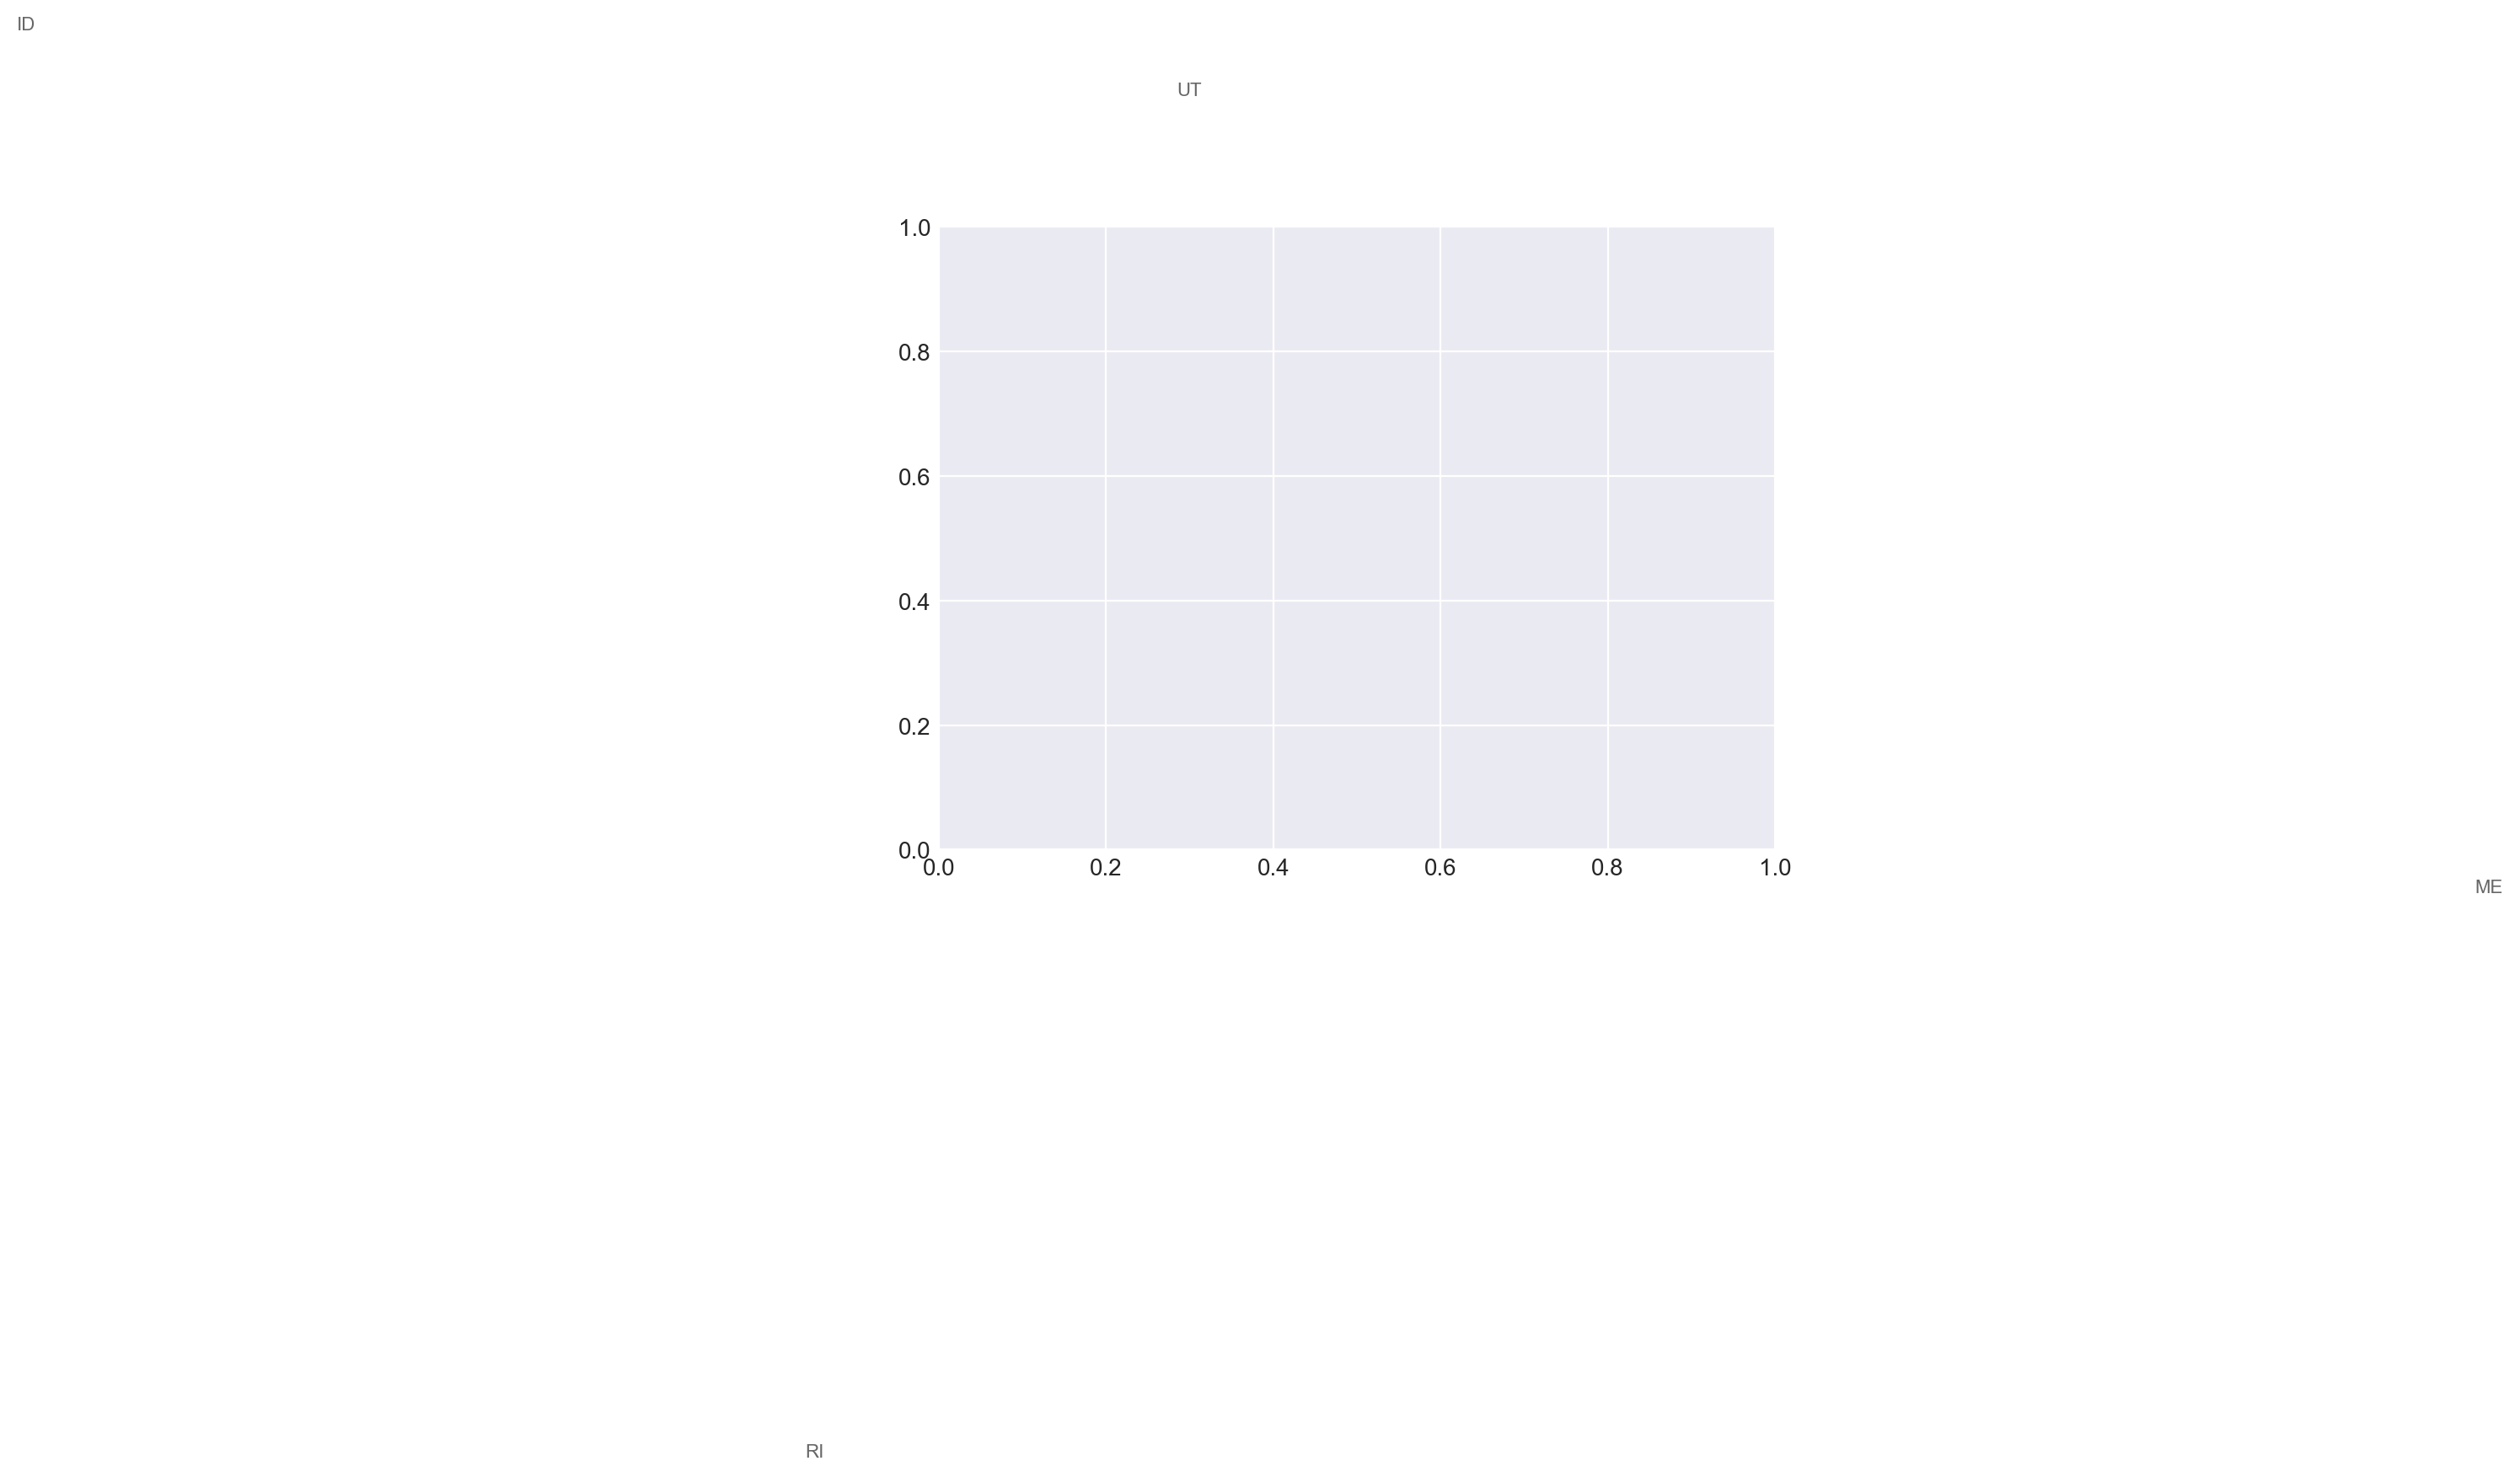

In [20]:
states = ['RI', 'ME', 'UT', 'ID']
for state in states:
    idx = d[d.Loc == state].index[0]  
    plt.text(d.D.iloc[idx], mu_means[idx], state, 
            fontsize=8, alpha=0.7, ha='left')

#### Code 5.18

In [21]:
N = 100
x_real = np.random.normal(0,1,N)
x_spur = np.random.normal(x_real, 1, N)
y = np.random.normal(x_real, 1, N)
d = pd.DataFrame({'x_real': x_real, 'x_spur': x_spur, 'y': y})


#### Code 5.19

In [22]:
d = pd.read_csv('data/WaffleDivorce.csv', sep=';')

d['A'] = scale.fit_transform(d[['MedianAgeMarriage']])
d['D'] = scale.fit_transform(d[['Divorce']])
d['M'] = scale.fit_transform(d[['Marriage']])

with pm.Model() as m5_3_A:
    sigma = pm.Exponential('sigma', 1)
    bM = pm.Normal('bM', mu=0, sigma=0.5)
    bA = pm.Normal('bA', mu=0, sigma=0.5)
    a = pm.Normal('a', mu=0, sigma=0.2)
    
    mu = pm.Deterministic('mu', a + (bM * d['M']) + (bA * d['A']))
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d['D'])

    sigma_M = pm.Exponential('sigma_M', 1)
    aM = pm.Normal('aM', 0,.2)
    bAM = pm.Normal('bAM', 0, .5)
    mu_M = pm.Deterministic('mu_M', aM + (bAM *d.A))

    M = pm.Normal('M', mu=mu_M, sigma=sigma_M, observed=d['M'])
    
    m5_3_A_trace = pm.sample(1000, tune=1000, cores=1, chains=4)
    m5_3_A_post = pm.sample_posterior_predictive(m5_3_A_trace)

var_names = [name for name in m5_3_A_trace.posterior.keys() if name not in ['mu_M', 'mu']]

pm.summary(m5_3_A_trace.posterior[var_names])


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, bM, bA, a, sigma_M, aM, bAM]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [D, M]


Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.060,0.159,-0.368,0.233,0.003,0.002,4010.0,2587.0,1.0
bA,-0.609,0.159,-0.896,-0.308,0.002,0.002,4088.0,3255.0,1.0
a,-0.000,0.100,-0.186,0.191,0.001,0.002,5115.0,2842.0,1.0
aM,-0.000,0.093,-0.172,0.174,0.001,0.002,5146.0,2359.0,1.0
bAM,-0.693,0.100,-0.887,-0.508,0.001,0.001,5267.0,2994.0,1.0
sigma,0.836,0.089,0.677,1.001,0.001,0.001,4691.0,2833.0,1.0
sigma_M,0.720,0.076,0.587,0.869,0.001,0.001,5026.0,2725.0,1.0


#### Code 5.20

In [23]:
A_seq = np.linspace(-2, 2, 30).flatten()

#### Code 5.21

In [24]:

a_posterior = m5_3_A_trace.posterior.a.values.flatten()  
bM_posterior = m5_3_A_trace.posterior.bM.values.flatten()  
bA_posterior = m5_3_A_trace.posterior.bA.values.flatten()  
aM_posterior = m5_3_A_trace.posterior.aM.values.flatten()  
bAM_posterior = m5_3_A_trace.posterior.bAM.values.flatten() 

#A_seq = np.asarray(A_seq).flatten()  # Shape: (len(A_seq),)

counterfactual_M = aM_posterior[:, None] + bAM_posterior[:, None] * A_seq[None, :]

counterfactual_D = (
    a_posterior[:, None]
    + bM_posterior[:, None] * counterfactual_M
    + bA_posterior[:, None] * A_seq[None, :]
)

mean_counterfactual_D = counterfactual_D.mean(axis=0)  


hdi_counterfactual_D = np.array([az.hdi(counterfactual_D[:, i], hdi_prob=0.89) 
                                  for i in range(len(A_seq))])


#### Code 5.22

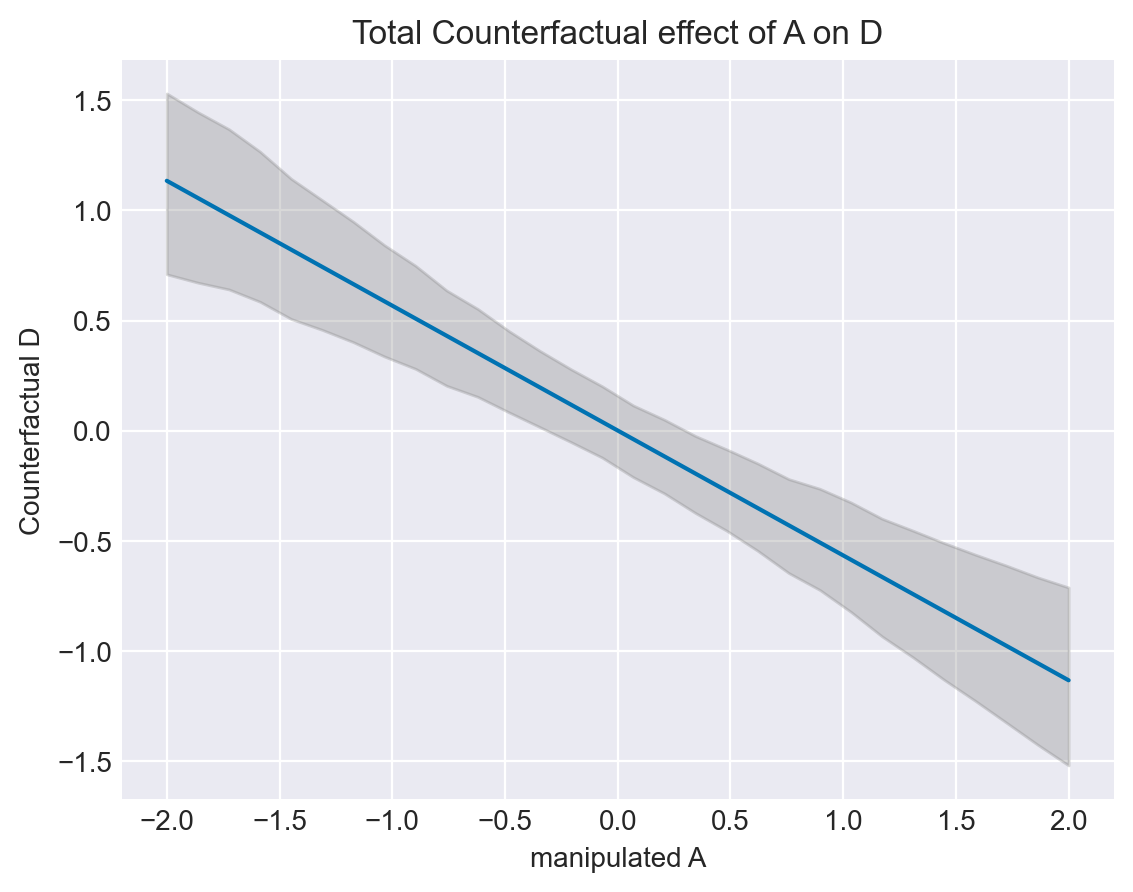

In [25]:

plt.plot(A_seq, mean_counterfactual_D)
plt.fill_between(A_seq, hdi_counterfactual_D[:, 0], hdi_counterfactual_D[:, 1], 
                 alpha=0.3, color='grey')
plt.xlabel('manipulated A')
plt.ylabel('Counterfactual D')
plt.title('Total Counterfactual effect of A on D');

#### Code 5.23

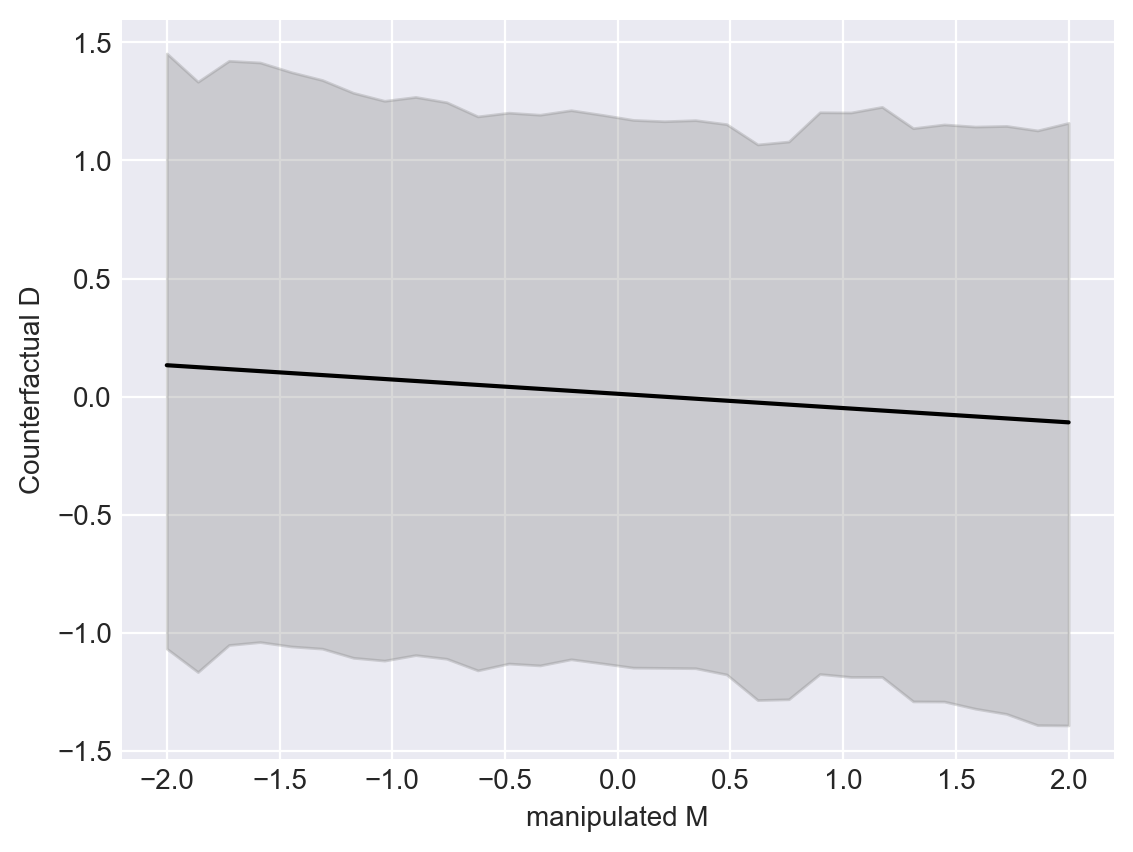

In [26]:
M_seq = np.linspace(-2, 2, 30).flatten()
A = np.repeat(0, len(M_seq))
a_posterior = m5_3_A_trace.posterior.a.values.flatten()
bM_posterior = m5_3_A_trace.posterior.bM.values.flatten()
bA_posterior = m5_3_A_trace.posterior.bA.values.flatten()
sigma_M = m5_3_A_trace.posterior.sigma_M.values.flatten()

D_counterfactual = a_posterior[:, None] + bM_posterior[:, None] * M_seq + bA_posterior[:, None] * A + np.random.normal(0, sigma_M)[:, None]


D_mean = D_counterfactual.mean(0)
D_PI = az.hdi(D_counterfactual, hdi_prob = .89)

plt.plot(M_seq, D_mean, color = 'black');
plt.fill_between(M_seq, D_PI[:,0], D_PI[:,1], color = 'grey', alpha = .3);
plt.xlabel('manipulated M')
plt.ylabel('Counterfactual D');


#### Code 5.24

In [27]:
A_seq = np.linspace(-2, 2, 30).flatten()

#### Code 5.25

In [28]:
post = m5_3_A_trace.posterior.to_dataframe().reset_index()

M_sim = np.random.normal(post.mu_M, post.sigma_M, size = len(post)) 

#### Code 5.26

In [29]:
D_sim = np.random.normal(post.mu, post.sigma, size = len(post))

#### Code 5.27

In [30]:
d = pd.read_csv('data/milk.csv', sep=';')

#### Code 5.28

In [31]:
d['K'] = scale.fit_transform(d[['kcal.per.g']])
d['N'] = scale.fit_transform(d[['neocortex.perc']])
d['M'] = scale.fit_transform(np.log(d[['mass']]))

#### Code 5.29 

In [32]:
d[d['neocortex.perc'].isna()]

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.830572,NaN,-0.422348
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.145842,NaN,-0.312595
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.019734,NaN,-0.575027
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.263087,NaN,-0.394336
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,1.691584,NaN,-1.069445
13,New World Monkey,Leontopithecus rosalia,0.71,36.90,21.27,41.83,0.60,NaN,0.430506,NaN,-1.170337
14,Old World Monkey,Chlorocebus pygerythrus,0.73,39.17,14.65,46.18,3.47,NaN,0.556614,NaN,-0.118481
16,Old World Monkey,M fuscata,0.72,53.05,13.00,33.95,7.08,NaN,0.493560,NaN,0.308931
18,Old World Monkey,M sinica,0.79,48.90,13.91,37.19,7.94,NaN,0.934937,NaN,0.377641
20,Ape,Nomascus concolor,0.48,15.96,12.52,71.52,7.59,NaN,-1.019734,NaN,0.350621


#### Code 5.31

In [33]:
dcc = d.dropna()

#### Code 5.32 

In [34]:
with pm.Model() as m5_5:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a',0, 1)
    bN = pm.Normal('bN', 0, 1)
    mu = pm.Deterministic('mu', a + bN * dcc.N)
    K = pm.Normal('K', mu =mu, sigma = sigma, observed = dcc.K)
    trace_m5_5_draft = pm.sample(cores = 1)
    post_m5_5_draft = pm.sample_posterior_predictive(trace_m5_5_draft )

# You _should_ get lots of warnings about too many Divergences above.
# This will be explained why in preceeding code blocks.


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bN]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [K]


Output()

#### Code 5.33

Sampling: [K, a, bN, sigma]


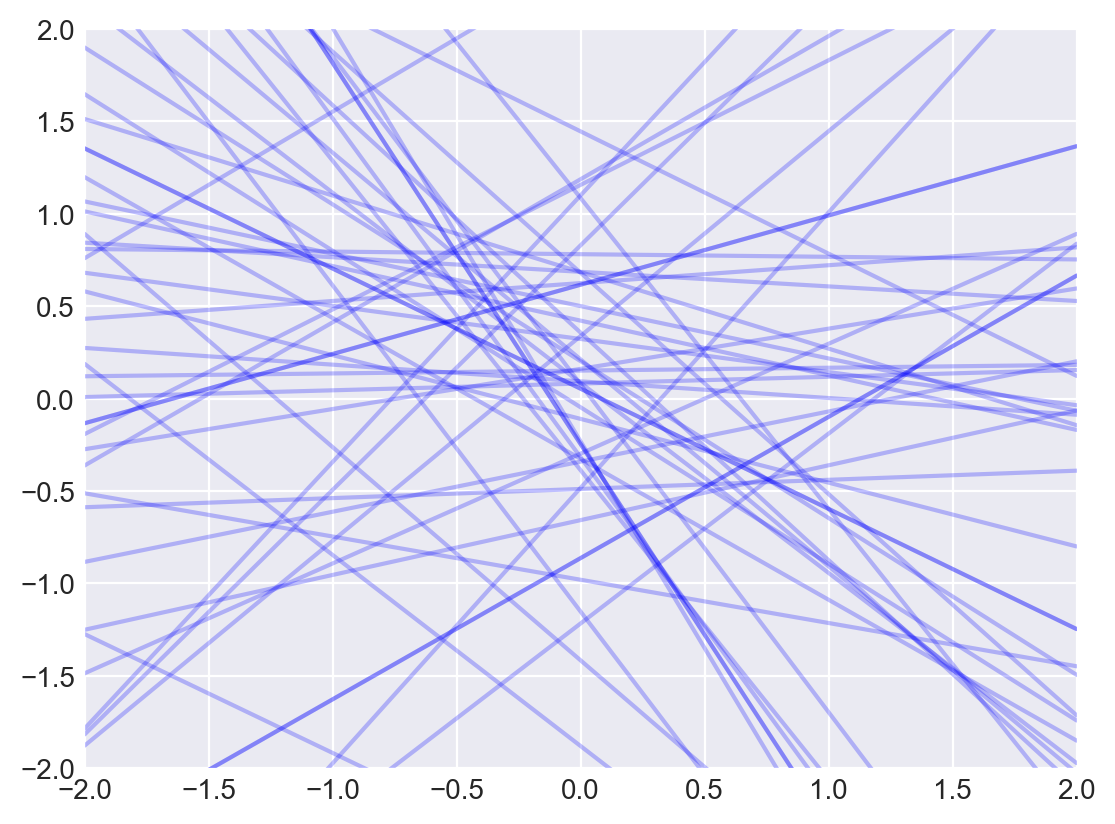

In [35]:
with m5_5:
    prior = pm.sample_prior_predictive(1000).prior.to_dataframe().reset_index()
xseq = np.linspace(-2,2,100)

for _, column in prior.sample(50).iterrows():
    y = column.a + column.bN * xseq 
    plt.plot(xseq,y, color = 'blue', alpha =.25)
    plt.xlim(-2,2)
    plt.ylim(-2,2)

#### Code 5.34

In [36]:
with pm.Model() as m5_5:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a',0, .2)
    bN = pm.Normal('bN', 0, .5)
    mu = pm.Deterministic('mu', a + bN * dcc.N)
    K = pm.Normal('K', mu =mu, sigma = sigma, observed = dcc.K)
    trace_m5_5 = pm.sample(cores = 1)
    post_m5_5 = pm.sample_posterior_predictive(trace_m5_5)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bN]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [K]


Output()

#### Code 5.35

In [37]:
pm.summary(trace_m5_5, var_names = ['a', 'bN', 'sigma'], hdi_prob = .89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.039,0.166,-0.208,0.307,0.003,0.004,2634.0,1346.0,1.0
bN,0.126,0.245,-0.228,0.543,0.006,0.005,1770.0,1554.0,1.0
sigma,1.129,0.212,0.816,1.446,0.005,0.003,2182.0,1433.0,1.0


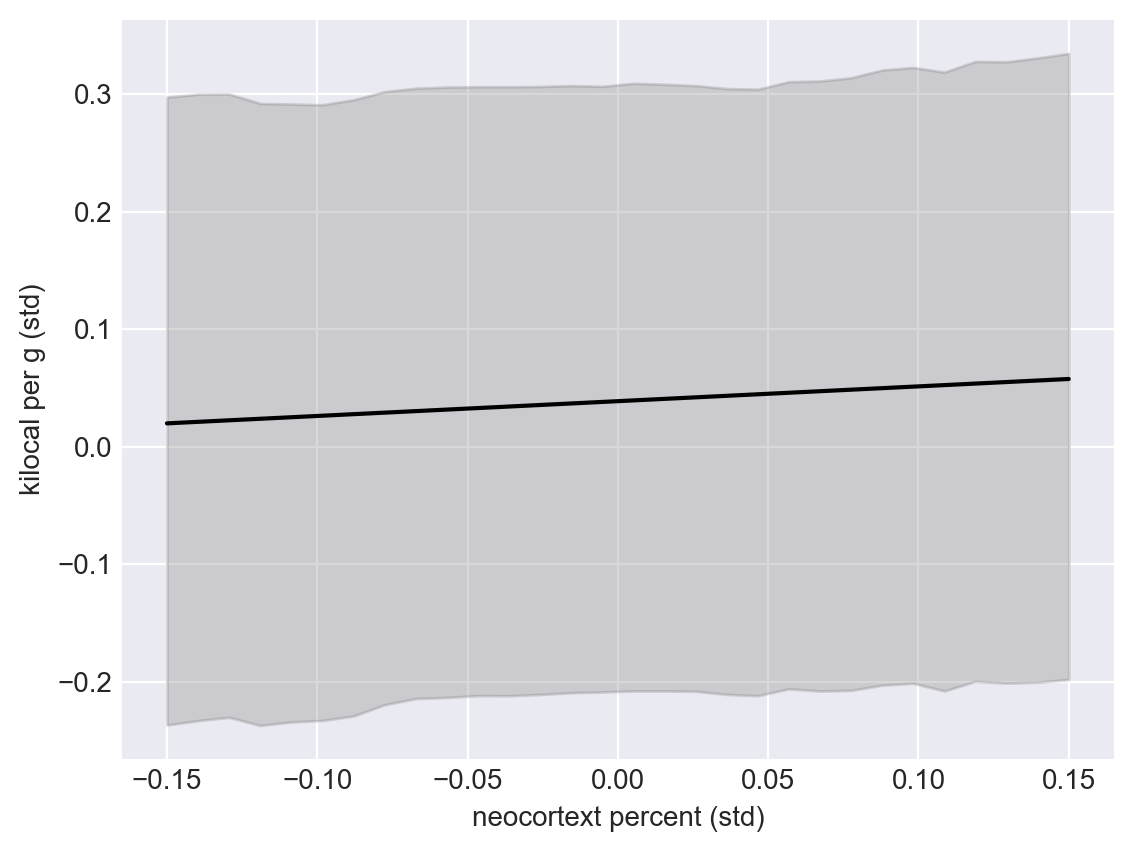

In [38]:
xseq = np.linspace(-.15, .15, 30)
post_df = trace_m5_5.posterior.to_dataframe().reset_index()

post_a = post_df['a'].values
post_bN = post_df['bN'].values

post_mu = post_a[:, None] + post_bN[:, None] * xseq[None, :]

post_mu_means = post_mu.mean(0)
post_mu_hdi = az.hdi(post_mu, hdi_prob = .89)


plt.plot(xseq, post_mu_means, color = 'black')
plt.fill_between(xseq, post_mu_hdi[:,0], post_mu_hdi[:,1], color = 'grey', alpha = .3)
plt.xlabel('neocortext percent (std)')
plt.ylabel('kilocal per g (std)');

#### Code 5.37

In [39]:
with pm.Model() as m5_6:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a',0, .2)
    bM = pm.Normal('bM', 0, .5)
    mu = pm.Deterministic('mu', a + bM * dcc.M)
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = dcc.K)
    trace_m5_6 = pm.sample(cores = 1)

pm.summary(trace_m5_6, var_names = ['a', 'bM', 'sigma'], hdi_prob = .89)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bM]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.044,0.157,-0.223,0.274,0.003,0.003,2761.0,1402.0,1.0
bM,-0.276,0.210,-0.594,0.071,0.004,0.003,2662.0,1483.0,1.0
sigma,1.078,0.199,0.772,1.343,0.004,0.003,2337.0,1387.0,1.0


#### Code 5.38

In [40]:
with pm.Model() as m5_7:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a',0, .2)
    bN = pm.Normal('bN', 0, .5)
    bM = pm.Normal('bM', 0, .5)
    mu = pm.Deterministic('mu', a + bN * dcc.N + bM * dcc.M)
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = dcc.K)
    trace_m5_7 = pm.sample(cores = 1)
pm.summary(trace_m5_7, var_names = ['a', 'bN', 'bM', 'sigma'], hdi_prob = .89)
    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bN, bM]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.055,0.137,-0.160,0.280,0.004,0.003,1457.0,1484.0,1.0
bN,0.598,0.274,0.184,1.058,0.008,0.005,1326.0,1046.0,1.0
bM,-0.639,0.249,-1.045,-0.270,0.007,0.005,1319.0,1129.0,1.0
sigma,0.883,0.177,0.627,1.142,0.005,0.004,1302.0,1485.0,1.0


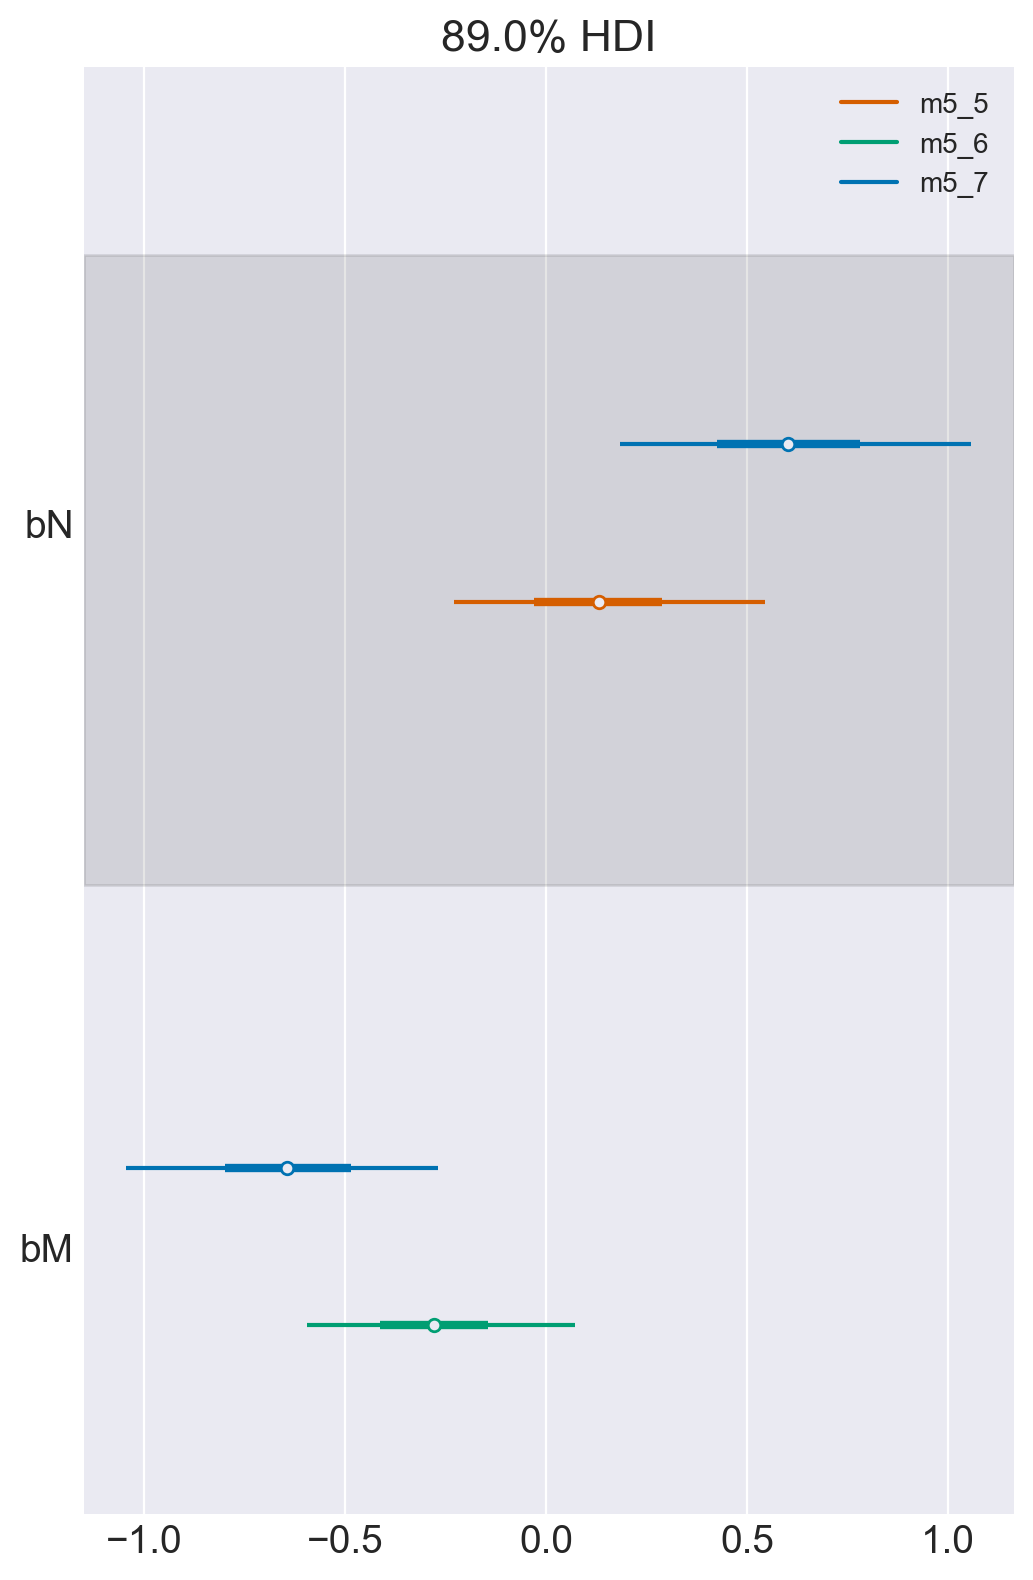

In [41]:
az.plot_forest([trace_m5_7, trace_m5_6, trace_m5_5], 
var_names = ['bN', 'bM',], 
combined = True, 
model_names = ['m5_7', 'm5_6', 'm5_5'],
hdi_prob = .89);

#### Code 5.40

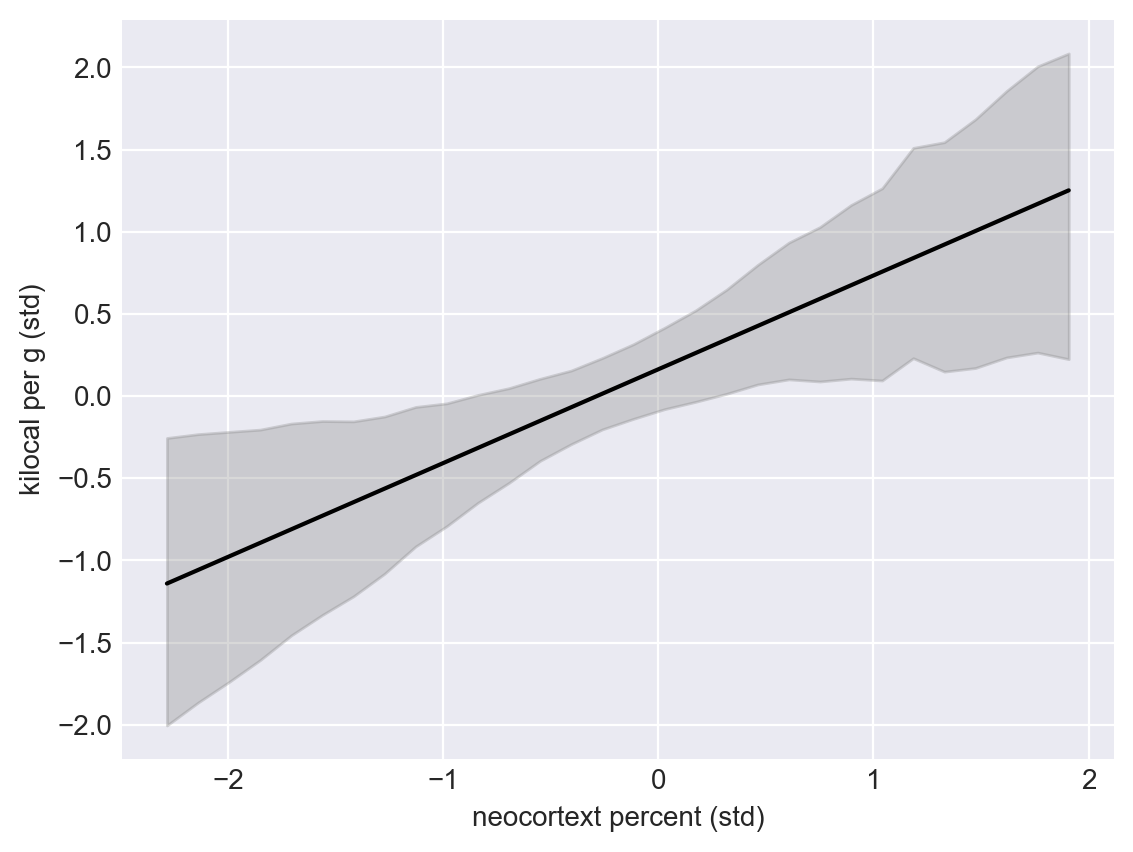

In [42]:
xseq = np.linspace(dcc.M.min()-.15, dcc.M.max() + .15, 30)
post_df = trace_m5_7.posterior.to_dataframe().reset_index()
M = np.repeat(0, len(xseq))
N = np.linspace(-2, 2, 30).flatten()
post_a = post_df['a'].values
post_bN = post_df['bN'].values
post_bM = post_df['bM'].values

mu_M = post_a[:, None] + post_bN[:, None] * N[None, :] + post_bM[:, None] * M[None, :]

mu_M_means = mu_M.mean(0)
mu_M_hdi = az.hdi(mu_M, hdi_prob = .89)


plt.plot(xseq, mu_M_means, color = 'black')
plt.fill_between(xseq, mu_M_hdi[:,0], mu_M_hdi[:,1], color = 'grey', alpha = .3)
plt.xlabel('neocortext percent (std)')
plt.ylabel('kilocal per g (std)');


#### Code 5.41

In [43]:
# M -> K <- N 
# M -> N 

n = 100
M = np.random.normal(0, 1, n) 
N = np.random.normal(M, 1, n)
K = np.random.normal(N-M, 1, n)

d = pd.DataFrame({'M': M, 'N': N, 'K': K})




#### Code 5.42

In [44]:
# M -> K <- N 
# M -> N 

n = 100
M = np.random.normal(0, 1, n) 
N = np.random.normal(M, 1, n)
K = np.random.normal(N-M, 1, n)

d = pd.DataFrame({'M': M, 'N': N, 'K': K})

# M -> K <- N
# M <- U -> N 

n = 100
U = np.random.normal(0, 1, n)
M = np.random.normal(U, 1, n)
N = np.random.normal(U, 1, n)
K = np.random.normal(N-M, 1, n)

d = pd.DataFrame({'M': M, 'N': N, 'K': K})


#### Code 5.43

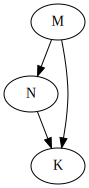

[]

In [45]:
dag5_7_1 = CausalGraphicalModel(
    nodes=["K", "M", "N"],
    edges=[("M", "N"), ("M", "K"), ("N","K")],
)

dag5_7_2 = CausalGraphicalModel(
    nodes=["K", "M", "N"],
    edges=[("M", "N"), ("M", "K"), ("N","K")],
)


# List conditional independencies implied by the DAG
display(dag5_7_1.draw())
dag5_7_1.get_all_independence_relationships()

#### Code 5.43

In [46]:
d = pd.read_csv('data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### Code 5.44

In [47]:
mu_female = np.random.normal(178, 20, 1000)
mu_male = np.random.normal(178, 20, 1000) + np.random.normal(0, 10, 1000)

pd.DataFrame({'mu_female': mu_female, 'mu_male': mu_male}).describe()


,mu_female,mu_male
count,1000.000000,1000.000000
mean,177.423796,176.829805
std,20.745388,21.245182
min,110.494496,110.329061
25%,163.681636,162.734476
50%,177.629411,176.737973
75%,192.391692,190.601923
max,244.206251,241.357686


#### Code 5.46

In [48]:
d['Sex'] = np.where(d.male == 1, 1, 0)
d.Sex.head()

0    1
1    0
2    0
3    1
4    0
Name: Sex, dtype: int64

#### Code 5.47

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    a = pm.Normal('a', 178, 20, shape = 2)
    mu = pm.Deterministic('mu', a[d.Sex])
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.height)
    trace_m5_8 = pm.sample(cores = 1)
pm.summary(trace_m5_8, var_names = ['a', 'sigma'], hdi_prob = .89)


    

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],134.887,1.598,132.306,137.331,0.030,0.021,2865.0,1687.0,1.0
a[1],142.583,1.698,139.737,145.171,0.032,0.022,2859.0,1377.0,1.0
sigma,27.401,0.821,26.029,28.614,0.016,0.011,2700.0,1622.0,1.0


: 

#### Code 5.48

In [ ]:
post = trace_m5_8.posterior.to_dataframe().reset_index()
post['post_diff'] = post.a[post.a_dim_0 == 1].values[:, None] - post.a[post.a_dim_0 == 0].values[None, :]
pm.summary(post, var_names = ['a','sigma','post_diff'], hdi_prob = .89)


#### Code 5.49

In [3]:
d = pd.read_csv('data/milk.csv', sep=';') 
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

#### Code 5.50

In [4]:
d['clade_id'], clade_unique = pd.factorize(d.clade)

#### Code 5.51

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([<Axes: title={'center': '89.0% HDI'}>], dtype=object)

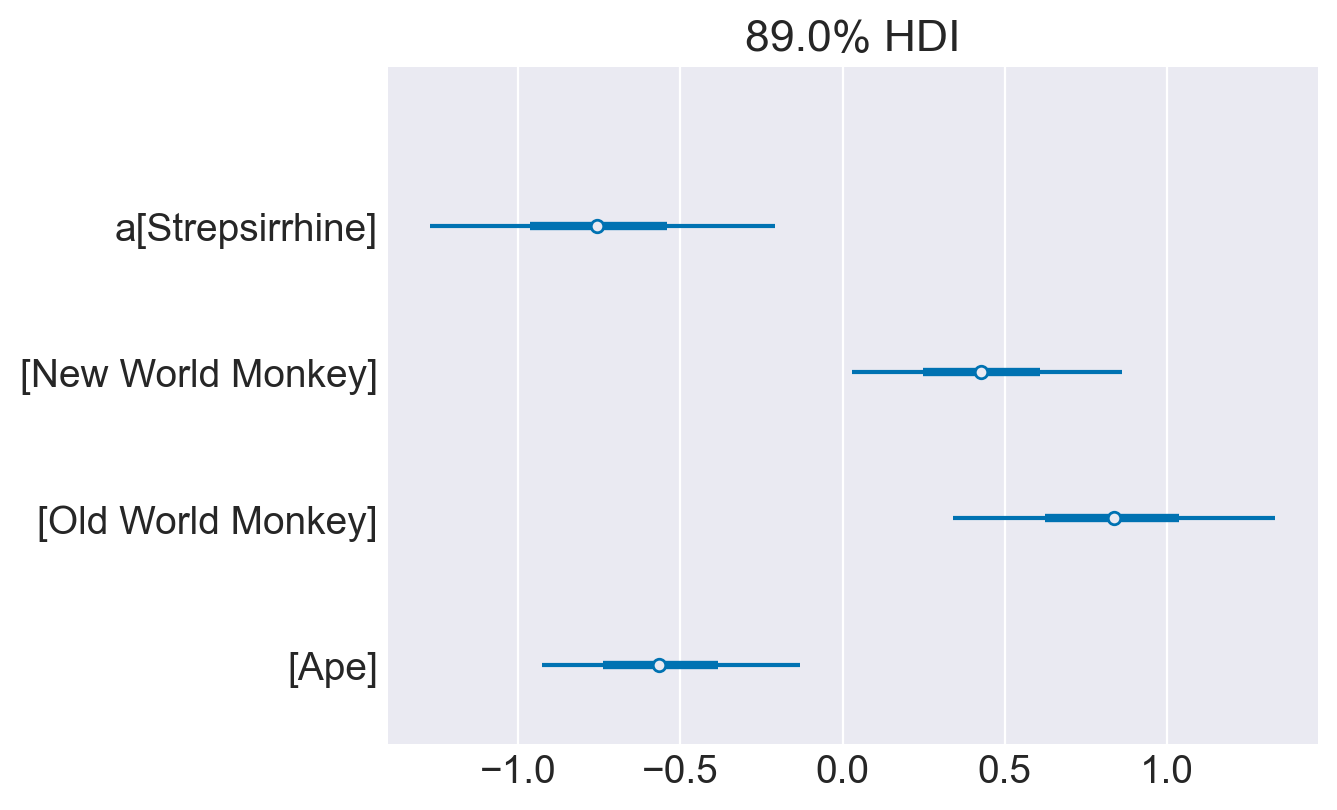

In [ ]:
d['K'] = scale.fit_transform(d[['kcal.per.g']]) 

coords = {'clade_id': clade_unique} #this is the equivlent of 'labels' in the rethinking package

with pm.Model(coords = coords) as m5_9:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0, 1, dims = 'clade_id')
    mu = pm.Deterministic('mu', a[d.clade_id])
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)
    trace_m5_9 = pm.sample(cores = 1)

az.plot_forest(trace_m5_9, var_names = ['a'], combined = True, hdi_prob = .89)    
    

#### Code 5.52

In [7]:
np.random.seed(63)
d['house'] = rand_array = np.random.randint(0, 4, size=d.shape[0])

#### Code 5.53

In [10]:
coords['house'] = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']


with pm.Model(coords = coords) as m5_10:
    sigma = pm.Exponential('sigma', 1)
    h = pm.Normal('h', mu = 0, sigma = .5, dims = 'clade_id')
    a = pm.Normal('a', mu = 0, sigma = .5, dims = 'house')
    mu = pm.Deterministic('mu', a[d.clade_id] + h[d.house])
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)

    m5_10_trace = pm.sample(cores = 1, chains = 4)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, h, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
